<a href="https://colab.research.google.com/github/aseddin/F22_ECE4715/blob/main/6_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

Predict a value using the weighted sum of the $n$ input features

$$\hat{y} = w_0 + w_1 x_1 + w_2 x_2 + \dots + w_n x_n$$

$w_0$ is the bias and $w_i$ are the weights

We can rewrite the linear regression equation in vector form:

$$\hat{y} = h_w(\bf{x}) = w_0 + \bf{w}^T x$$

or 

$$\hat{y} = h_w(\bf{x}) = \bf{W}^T \bf{x}$$

where $\bf{W}$ includes the bias and $x_0$ is always 1

Our task is to find $\bf{W}$ that minimizes using the $m$ instances in the training set:

$$\text{RMSE}(\bf{W}) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{y}^{(i)} - y^{(i)})^2}$$

$$\text{RMSE}(\bf{W}) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\bf{W}^T \bf{x}^{(i)} - y^{(i)})^2}$$

Or easier

$$\text{MSE}(\bf{W}) = \frac{1}{m}\sum_{i=1}^{m}(\bf{W}^T \bf{x}^{(i)} - y^{(i)})^2$$

In [1]:
# code to set things up

# importing common libraries
import numpy as np
import pandas as pd

# Things related to figures and plots
# make figures look nicer
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# figure saving function
from pathlib import Path
IMAGES_PATH = Path() / "images" / "linear_regression"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
# Generate some linear looking data

m = 100 # number of instances
np.random.seed(42)
X = 2 * np.random.rand(m, 1) # column vector

w0 = 4
w1 = 3

y = w0 + w1 * X + np.random.randn(m, 1) # column vector
X[:5]

array([[0.74908024],
       [1.90142861],
       [1.46398788],
       [1.19731697],
       [0.31203728]])

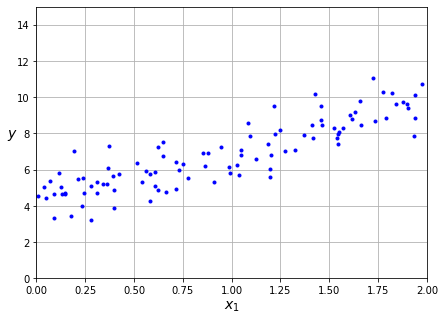

In [3]:
# plot the generated data

plt.figure(figsize=(7, 5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

In [4]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # add x0 = 1 to each instance
X_b[:5]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728]])

## The Normal Equation

The normal equations is a closed-form solution that can find $\bf{W}$ that minimizes the cost function:

$$
\text{MSE}(\bf{W}) = \frac{1}{m} \sum_{i=1}^{m}(\bf{W}^T \bf{x}^{(i)} - y^{(i)})^2
$$

The solution:

$$
\hat{\bf{W}}=(\bf{X}^T\bf{X})^{-1}\bf{X}^T\bf{Y}
$$

$\hat{\bf{W}}$ is the value that minimizes the $\text{MSE}(\bf{W})$

$X^{\dagger} = (\bf{X}^T\bf{X})^{-1}\bf{X}^T$ is the left pseudo inverse of the (non-square) matrix $\bf{X}$. Specifically it is the Moore-Penrose inverse

We will show the Normal euqtion using simple linear regression (one feature)



In [5]:
# The normal equation solution

w_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

print("w_best=\n", w_best)
print("w0=", w0)
print("w1=", w1)

w_best=
 [[4.21509616]
 [2.77011339]]
w0= 4
w1= 3


It is easy to make predictions on a new input instance using `w_best`

In [6]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ w_best
y_predict

array([[4.21509616],
       [9.75532293]])

Let's plot the model's predictions

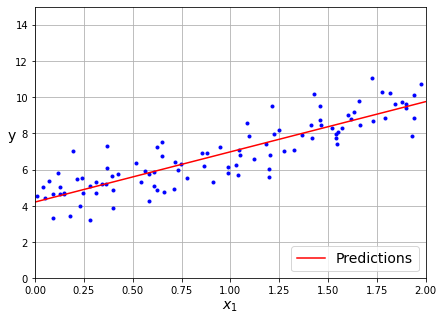

In [7]:
plt.figure(figsize=(7, 5))
plt.plot(X, y, "b.")
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="lower right")
plt.show()

If `np.linalg.inv` didn't work because $(\bf{X}^T\bf{X})^{-1}$ is not invertable. You can compute the pseudoinverse $X^{\dagger} = (\bf{X}^T\bf{X})^{-1}\bf{X}^T$ using `np.linalg.pinv()` which utilizes SVD

$$
\hat{\bf{W}}=X^{\dagger}\bf{Y}
$$

In [8]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

`sklearn`'s `LinearRegression` generates the same result

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
print("bias=", lin_reg.intercept_)
print("weights=", lin_reg.coef_)

bias= [4.21509616]
weights= [[2.77011339]]


In [10]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

## Gradient Descent

### Batch Gradient Descent

1. Pick a cost function:

  For linear regression:

$$
\text{MSE}(\bf{W}) = \frac{1}{m}\sum_{i=1}^{m} (\bf{W}^{T}X^{(i)}-y^{(i)})^2
$$

2. Compute the gradient of the cost function with regard to each model parameter $w_j$

  $$
  \frac{\partial}{\partial w_j}\text{MSE}(\bf{W}) = \frac{2}{m}
  \sum_{i=1}^{m} (\bf{W}^T X^{(i)} - y^{(i)})x_j^{(i)}
  $$

  Partial derivatives can be computed all together with the following gradient vector

$$
\nabla_W \text{MSE}(\bf{W}) = 
\begin{bmatrix}
\frac{\partial}{\partial w_0}\text{MSE}(\bf{W}) \\
\frac{\partial}{\partial w_1}\text{MSE}(\bf{W}) \\
\vdots\\
\frac{\partial}{\partial w_n}\text{MSE}(\bf{W}) \\
\end{bmatrix}
= \frac{2}{m}X^T(XW-y)
$$

3. Take a gradient step
$$
\bf{W}^{\text{(next step)}} = \bf{W}^{\text{(current step)}} - \eta \nabla_W \text{MSE}(\bf{W})
$$

  The gradient points uphill, to go downhill we subtract $\nabla_W\text{MSE}(\bf{W})$ from $\bf{W}$. $\eta$ is the learning rate and it controls the step size

4. Repeat (step 2 through 4) untill a certain condition is met (i.e. number of maximum epochs is reached, the norm of $\bf{W}$ is below a threshold $\epsilon$...etc)

At each gradient descent step, the full training set $\bf{X}$ is used; hence, it is called _**Batch**_ Gradient Descent. It is usally slow if the training set is very large; however, it scales well with the number of features and will perform much faster than the Normal Equation

In [11]:
# Batch Gradient Descent

# Learning rate
eta = 0.1

# Number of epochs (i.e. steps)
n_epochs = 1000

m = len(X_b) # number of training instances

w = np.random.randn(2, 1) # random initialization

w_path_bgd = [] # will be used to compare with stochastic GD and mini-batch GD

for epoch in range(n_epochs):
  gradients = 2 / m * X_b.T @ (X_b @ w - y)
  w = w - eta * gradients
  w_path_bgd.append(w)
  

The learned model parameters:

In [12]:
w

array([[4.21509616],
       [2.77011339]])

This the same as we found using the Normal Equation

#### Showing the effect of the learing rate $\eta$

In [13]:
# Learning rate
#eta = 0.1 # converges
#eta = 0.02 # converges slowly
eta = 0.5 # diverges

epoch = 0

m = len(X_b) # number of training instances
np.random.seed(42)
w = np.random.randn(2, 1) # random initialization

from sklearn.metrics import mean_squared_error

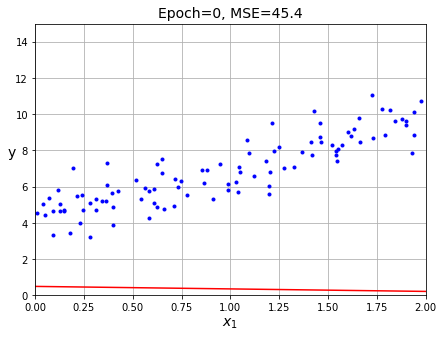

In [14]:
# run this cell several times to see how Gradient Descent progresses with each epoch

# plot the raw data points
plt.figure(figsize=(7, 5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()

# compute the performance measure (MSE)
mse = mean_squared_error(y, X_b @ w)
plt.title("Epoch={:d}, MSE={:.3}".format(epoch, mse))

y_new_predict = X_new_b @ w
plt.plot(X_new, y_new_predict, 'r-')

epoch = epoch + 1
gradients = 2 / m * X_b.T @ (X_b @ w - y)
w = w - eta * gradients

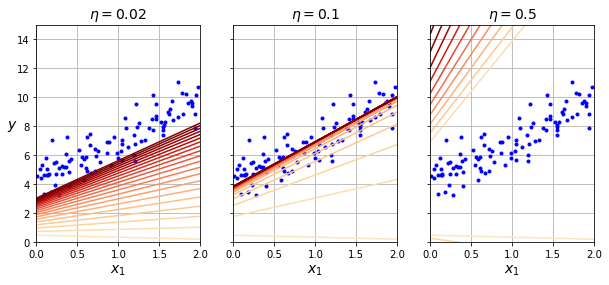

In [15]:
# Plot the first n_shown steps of gradient descent
# the color of the regressor gets darker and darker

import matplotlib as mpl

def plot_gradient_descent(w, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ w
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradients = 2 / m * X_b.T @ (X_b @ w - y)
        w = w - eta * gradients
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")

np.random.seed(42)
w = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(w, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
plot_gradient_descent(w, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(w, eta=0.5)
plt.show()

### Stochastic Gradient Descent (SGD)

Batch Gradient Descent uses the whole training set when computing gradients at each step, this is why it will be slow for large training sets. On the other hand, Stochastic Gradient Descent randomly selects one instance from the training set and uses it to compute the gradient in each training step. Clearly, stochastic gradient descent is fast because it only handles one instances at a time, and it is also more stochastic (or random) than batch gradient descent. The cost function fluctuates up and down depending on the randomly selected instance; however, it generally decreases on average. 

The gradient vector for stochastic gradient descent is:

$$
\nabla_W \text{MSE}(\bf{W}) = 
\begin{bmatrix}
\frac{\partial}{\partial w_0}\text{MSE}(\bf{W}) \\
\frac{\partial}{\partial w_1}\text{MSE}(\bf{W}) \\
\vdots\\
\frac{\partial}{\partial w_n}\text{MSE}(\bf{W}) \\
\end{bmatrix}
= 2{x^{(i)}}^T(x^{(i)}W-y^{(i)})
$$

SGD doesn't settle to the optimum solution because it keeps bouncing around it. One solution is to change the learning rate based on a learning schedule as we progress through the training. 

In [16]:
# Stochastic Gradient Descent

# Learning rate schedule
# learning schedule hyperparameters
t0, t1 = 5, 50
def learning_schedule(t):
  return t0 / (t + t1)

# Number of epochs 
n_epochs = 50

m = len(X_b) # number of training instances

np.random.seed(42)
w = np.random.randn(2, 1) # random initialization

w_path_sgd = [] # will be used to compare with batch GD and mini-batch GD

for epoch in range(n_epochs):
  for iteration in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index: random_index + 1]
    yi = y[random_index:random_index + 1]
    gradients = 2 * xi.T @ (xi @ w - yi) # for SGD, do not divide by m
    eta = learning_schedule(epoch * m + iteration)
    w = w - eta * gradients
    w_path_sgd.append(w)

In [17]:
w

array([[4.21076011],
       [2.74856079]])

Note that SGD went through the training set 50 times only (as opposed to 1000 for batch GD). It reached similar results faster

#### Showing the progress of SGD

In [18]:
n_epochs = 50

np.random.seed(42)
w = np.random.randn(2, 1) # random initialization

epoch = 0
iteration = 0

m = len(X_b) # number of training instances

from sklearn.metrics import mean_squared_error

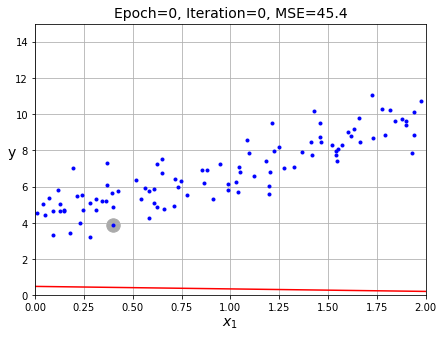

In [19]:
# run this cell several times to see how Stochastic Gradient Descent progresses with each step (not epoch)

# plot the raw data points
plt.figure(figsize=(7, 5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()

# compute the performance measure (MSE)
mse = mean_squared_error(y, X_b @ w)
plt.title("Epoch={:d}, Iteration={:d}, MSE={:.3}".format(epoch, iteration, mse))

y_new_predict = X_new_b @ w
plt.plot(X_new, y_new_predict, 'r-')

random_index = np.random.randint(m)
xi = X_b[random_index: random_index + 1]
yi = y[random_index: random_index + 1]
plt.scatter(xi[0][1], yi, s=180, zorder=-1, facecolors='#AAA')
gradients = 2 * xi.T @ (xi @ w - yi)
eta = learning_schedule(epoch * m + iteration)
w = w - eta * gradients

iteration = iteration + 1
if iteration == m:
  epoch = epoch + 1
  iteration = 0


The code above does not guarantee that each instance will only be used once in each epoch. In other words, some instances will be used more than once while others will not be used within each epoch

#### Using `SGDRegressor`

`sklearn` provides the `SGDRegressor` class to perform stohastic gradient descent regression

In [20]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000, penalty=None, eta0=0.01, 
    tol=1e-5, n_iter_no_change=100, random_state=42
)

# fit X not X_b as SGDRegressor will add the dummy feature automatically
# use y.ravel not y because fit() expects 1D targets of the shape (100, ) as opposed of (100, 2)
sgd_reg.fit(X, y.ravel()) 

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [21]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

### Mini-Batch Gradient Descent

Batch Gradient Descent uses the whole training set at each step; whereas, stochastic gradient descent uses a single random instance from the training set at each training step. Mini-Batch Gradient Descent is in between, it uses a small random set of instances called mini-batches at each training step. 

Mini-Batch Gradient Descent offers some performance boost from hardware optimization of matrix operations and it moves in the parameter space is less erratic fashion compared with stochastic gradient descent. 

The gradient vector for mini-batch gradient descent is:

$$
\nabla_W \text{MSE}(\bf{W}) = 
\begin{bmatrix}
\frac{\partial}{\partial w_0}\text{MSE}(\bf{W}) \\
\frac{\partial}{\partial w_1}\text{MSE}(\bf{W}) \\
\vdots\\
\frac{\partial}{\partial w_n}\text{MSE}(\bf{W}) \\
\end{bmatrix}
= \frac{2}{\text{batch size}}{x^{(batch)}}^T(x^{(batch)}W-y^{(batch)})
$$

In [22]:
# Mini-Batch Gradient Descent

from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
w = np.random.randn(2, 1) # random initialization

# Learning rate schedule
# learning schedule hyperparameters
t0, t1 = 200, 1000
def learning_schedule(t):
  return t0 / (t + t1)

w_path_mgd = []

for epoch in range(n_epochs):
  shuffled_indices = np.random.permutation(m)
  X_b_shuffled = X_b[shuffled_indices]
  y_shuffled = y[shuffled_indices]
  for iteration in range(n_batches_per_epoch):
    idx = iteration * minibatch_size
    xi = X_b_shuffled[idx:idx + minibatch_size]
    yi = y_shuffled[idx:idx + minibatch_size]
    gradients = 2/minibatch_size * xi.T @ (xi @ w - yi)
    eta = learning_schedule(iteration)
    w = w - eta * gradients
    w_path_mgd.append(w)

In [23]:
w

array([[4.2857119],
       [2.8119161]])

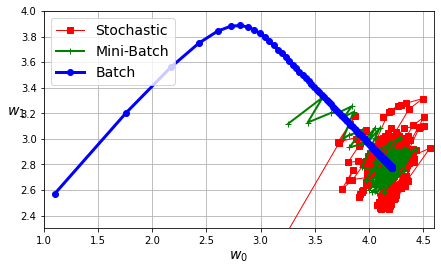

In [24]:
# Plot the parameter path taken using Batch GD, Stochastic GD, Mini-Batch GD

w_path_bgd = np.array(w_path_bgd)
w_path_sgd = np.array(w_path_sgd)
w_path_mgd = np.array(w_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(w_path_sgd[:, 0], w_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(w_path_mgd[:, 0], w_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-Batch")
plt.plot(w_path_bgd[:, 0], w_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")


plt.legend(loc="upper left")
plt.xlabel(r"$w_0$")
plt.ylabel(r"$w_1$", rotation=0)
plt.axis([1, 4.6, 2.3, 4])

plt.grid()
plt.show()

## Polynomial Regression

If the data is nonlinear, a straight line won't fit the data. Yet, a linear model can still be used. Just add powers of each feature as new features, then train a linear model on the extended set of features. This is call Polynomial Regression


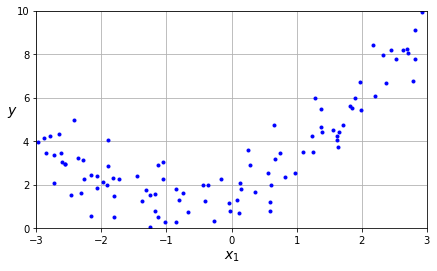

In [25]:
# Generate some nonlinear looking data

m = 100 # number of instances
np.random.seed(42)
X = 6 * np.random.rand(m, 1) - 3

w0 = 2    # bias
w1 = 1    # X
w2 = 0.5  # X**2

# Simple quadratic equation
y = w0 + w1 * X + w2 * X**2 + np.random.randn(m , 1)

plt.figure(figsize=(7, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

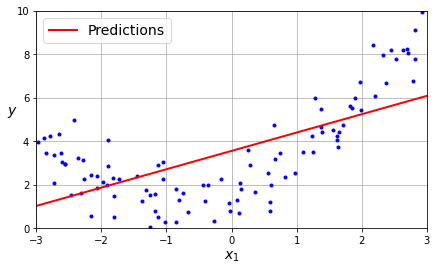

In [26]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

X_new = [[-3], [3]]
y_new = lin_reg.predict(X_new)

plt.figure(figsize=(7, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.legend(loc="upper left")
plt.grid()
plt.show()

Clearly, a line cannot fit the quadratic data properly so we should add polynomial features

In [27]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [28]:
X[0]

array([-0.75275929])

In [29]:
# contains the original x and its square
X_poly[0]

array([-0.75275929,  0.56664654])

We only have 1 feature, so `PolynomialFeatures` with `degree=2` generated one new feature. If we have more features, then we would have gotten the `degree` of each feature and an interaction term between all combinations of features up to `degree`

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

In [31]:
# The true weights
w0, w1, w2

(2, 1, 0.5)

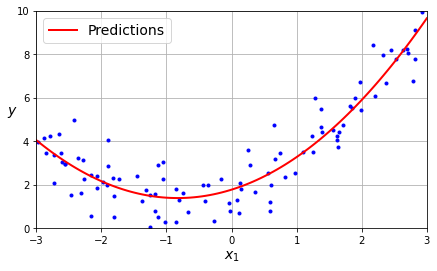

In [32]:
# plot the regressor

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(7, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.legend(loc="upper left")
plt.show()

What if we fit higher degree polynomial to the data

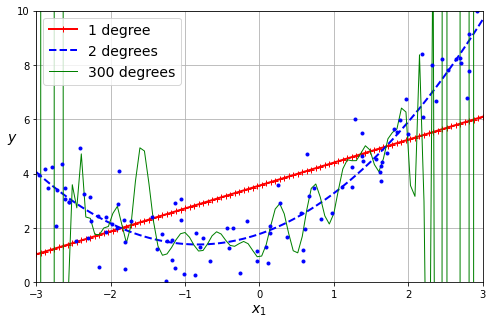

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

plt.figure(figsize=(8, 5))

train_rmse_by_degree = {}
valid_rmse_by_degree = {}

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    # StandardScaler is necessary to make all features of the same scale
    # this is especially important for higher degree polynomials
    std_scaler = StandardScaler()
    lin_reg = LinearRegression() 
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    train_rmse_by_degree[degree] = mean_squared_error(y, polynomial_regression.predict(X), squared=False)
    valid_rmse_by_degree[degree] = -np.mean(cross_val_score(polynomial_regression, X, y, scoring='neg_root_mean_squared_error', cv=5))
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Clearly the 300 degrees polynomial fits the training data better than the lower degree polynomials. However, this is not always a good thing. The model is clearly _**overfitting**_ the training data and will not generalize well.

The model that seem to generalize better is the quadratic model and this is reasonable because the data was generated using a quadratic equation. However, generally you will not know what function generated the data, so how should you decide how complex a model should be? Whether it is overfitting or underfitting the data?


## Learning Curves

In [34]:
print("Training RMSE scores:")
for r in train_rmse_by_degree:
  print(f"degree={r}\t RMSE={train_rmse_by_degree[r]}")

print("-----------------------")

print("Validation RMSE scores:")
for r in valid_rmse_by_degree:
  print(f"degree={r}\t RMSE={valid_rmse_by_degree[r]}")

Training RMSE scores:
degree=1	 RMSE=1.739127354922467
degree=2	 RMSE=0.8815858814376717
degree=300	 RMSE=0.6068183306007184
-----------------------
Validation RMSE scores:
degree=1	 RMSE=1.744832382371205
degree=2	 RMSE=0.9154954107199845
degree=300	 RMSE=2316032905174258.0


Learning Curves plot the training error and validation error as a function of the training iteration. Training iteration can be:
  * The epoch for models that are trained incrementally (i.e. using Gradient Descent). 
  * The training set size for models that are not trained incrementally (i.e. Linear Regression). Just increase the training size with each iteration.

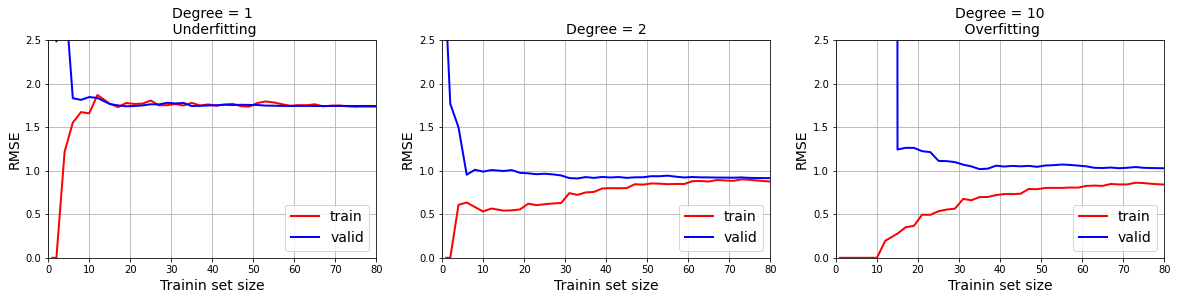

In [35]:
from sklearn.model_selection import learning_curve

# Plot the learning curve for degree = 1 (underfitting the training data)
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.plot(train_sizes, train_errors, "r-", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")

plt.xlabel("Trainin set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="lower right")
plt.axis([0, 80, 0, 2.5])
plt.title("Degree = 1\n Underfitting")

# Plot the learning curve for degree = 2
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.subplot(132)
plt.plot(train_sizes, train_errors, "r-", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")

plt.xlabel("Trainin set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="lower right")
plt.axis([0, 80, 0, 2.5])
plt.title("Degree = 2")

# Plot the learning curve for degree = 10 (overfitting the training data)
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1, 40), cv=5,
    scoring="neg_root_mean_squared_error"
)

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.subplot(133)
plt.plot(train_sizes, train_errors, "r-", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=2, label="valid")

plt.xlabel("Trainin set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="lower right")
plt.axis([0, 80, 0, 2.5])
plt.title("Degree = 10\n Overfitting")

plt.show()

### Bias/Variance Trade-Off

* Bias: Generalization error due to wrong assumptions. For example, assuming the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data. **More data will not help, you need more complex model or better features**

* Variance: Generalization error due to the model's excessive sensitivity to small variations in the training data. Models with high degrees of freedom (i.e. high-degree polynomials) is likely to have high variance and will overfit the training data. **More data might help reduce variance, or you need to use less complex models or regularize (or constrain) the model**

In general increasing a model's complexity will increase its variance and reduce its bias. Similarly, reducing a model's complexity will reduce its variance and increase its bias

## Regularizing Linear Models

Regularizing (or constraining) a model can help reduce overfitting (i.e. increase its bias and reduce its variance).

Polynomial models can be regularized by reducing the number of polynomial degrees. Linear models can be regularized by constraining the weights of the model.

### Ridge Regression

Is a regularized version of linear regression. 

The cost function $J(\bf{W})$ has an extra term that forces the model weights to be as small as possible in addition to fitting the data:

$$
J(\bf{W}) = \text{MSE}(\bf{W}) + \frac{\alpha}{m}
\sum_{i=1}^{n} w_{i}^{2}
$$

$$
J(\bf{W}) = \frac{1}{m}\sum_{i=1}^{m} (\bf{W}^{T}X^{(i)}-y^{(i)})^2 + \frac{\alpha}{m}
\sum_{i=1}^{n} w_{i}^{2}
$$

$\alpha$ is a hyperparameter that controls how much the model should be regularized. If $\alpha = 0$ you get just linear regression; however, if $\alpha$ is very large, then all weights end up very close to zero and the result is a flat line going through the data's mean.

$||w||_2 = \sqrt{\sum_{i=1}^{n} w_{i}^{2}}$  is the $\ell_2$ norm of the weight vector (and dosn't include the bias). Of course $||w||_2^2=\sum_{i=1}^{n} w_{i}^{2}$ is the square of the $\ell_2$ norm. That's why ridge regression is sometimes called $\ell_2$ regularization.

----

Note: The bias $w_0$ is not usualy regularized, that's why the additional term doesn't include it. 

Note: The cost function is used during training only. Once the model is trained unregularized perfromance metric should be used (i.e. MSE or RMSE without the extra term)

Note: The input features should be of the same scale (i.e. use `StandardScaler`) because Ridge regression is sensitive to the input scale (this applies to most regularized models)

----

The Gradient of the cost function with regard to each model parameter $w_j$ (except the bias)

$$
\frac{\partial}{\partial w_j} J(\bf{W}) = \frac{2}{m}
\sum_{i=1}^{m} (\bf{W}^T X^{(i)} - y^{(i)})x_j^{(i)} + 
\frac{2 \alpha}{m}w_j
$$

The gradient vector becomes:

$$
\nabla_W J(\bf{W}) = 
\begin{bmatrix}
\frac{\partial}{\partial w_0}\text{MSE}(\bf{W}) \\
\frac{\partial}{\partial w_1}J(\bf{W}) \\
\vdots\\
\frac{\partial}{\partial w_n}J(\bf{W}) \\
\end{bmatrix}
= \frac{2}{m}X^T(XW-y) + 
\begin{bmatrix}
0 \\
\frac{2 \alpha}{m}W
\end{bmatrix}
$$

Where $\bf{W}$ is the weight vector include the bias and $W$ is the weight vector without the bias

Ridge regression can also be computed using a closed-form equation (might be slow and numerically unstable):

$$
\hat{\bf{W}}=(\bf{X}^T\bf{X} + \alpha \bf{A})^{-1}\bf{X}^T\bf{Y}
$$

Where $\bf{A}$ is the identity matrix $\bf{I}$ with the top-left cell equal to 0 so the bias is not regularized


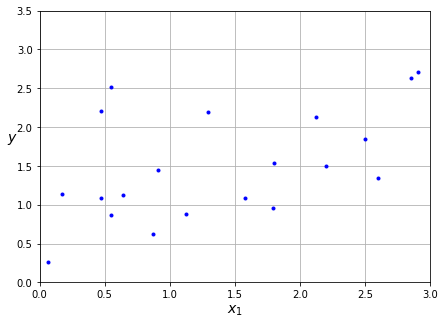

In [36]:
# Generate very noisy linear data
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)

w0 = 1
w1 = 0.5

y = w0 + w1 * X + np.random.randn(m, 1) / 1.5

X_new = np.linspace(0, 3, 100).reshape(100, 1)
X_new_b = add_dummy_feature(X_new)

plt.figure(figsize=(7, 5))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

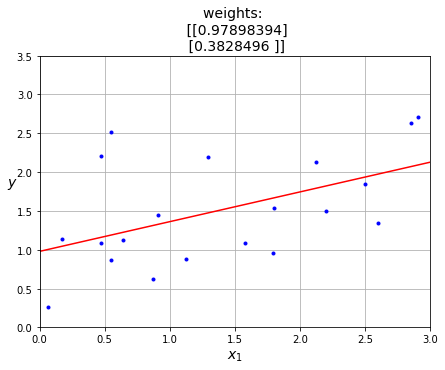

In [37]:
# Ridge Regression using Batch Gradient Descent

# Learning rate
eta = 0.1

# Regularization factor
alpha = 0.10

# Number of epochs (i.e. steps)
n_epochs = 1000

X_b = add_dummy_feature(X)

m = len(X_b) # number of training instances

w = np.random.randn(2, 1) # random initialization

for epoch in range(n_epochs):
  regularizer = 2 * alpha / m * w
  regularizer[0] = 0
  gradients = 2 / m * X_b.T @ (X_b @ w - y) + regularizer
  w = w - eta * gradients
  

# Plotting the predictions
y_new = X_new_b @ w

plt.figure(figsize=(7, 5))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.title(f"weights: \n {w}")
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

#### Using `sklearn`'s `Ridge` and `SGDRegressor`

In [38]:
# Using Ridge with ‘cholesky’ solver
# ‘cholesky’ solver uses the standard scipy.linalg.solve function to obtain a closed-form solution.

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.intercept_, ridge_reg.coef_

(array([0.97898394]), array([[0.3828496]]))

In [39]:
# Using Ridge with 'saga' solver
# uses a Stochastic Average Gradient descent, and ‘saga’ uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.
# 'sag' is a variant of Stochastic Gradient Descent

from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 0.1, solver="saga", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.intercept_, ridge_reg.coef_

(array([0.9777282]), array([[0.38376412]]))

In [40]:
# Using SGDRegressor with 'l2' penalty

# To get the same result as Ridge, use alpha = 0.1 / m
# The 'l2' penality regularizes (MSE + alpha X 'l2' squared) without dividing by m 

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000, penalty='l2', alpha=0.1/m, eta0=0.01, 
    tol=1e-5, n_iter_no_change=100, random_state=42
)

# fit X not X_b as SGDRegressor will add the dummy feature automatically
# use y.ravel not y because fit() expects 1D targets of the shape (100, ) as opposed of (100, 2)
sgd_reg.fit(X, y.ravel()) 

sgd_reg.intercept_, sgd_reg.coef_

(array([0.96619585]), array([0.3901924]))

#### Showing the effect of $\alpha$

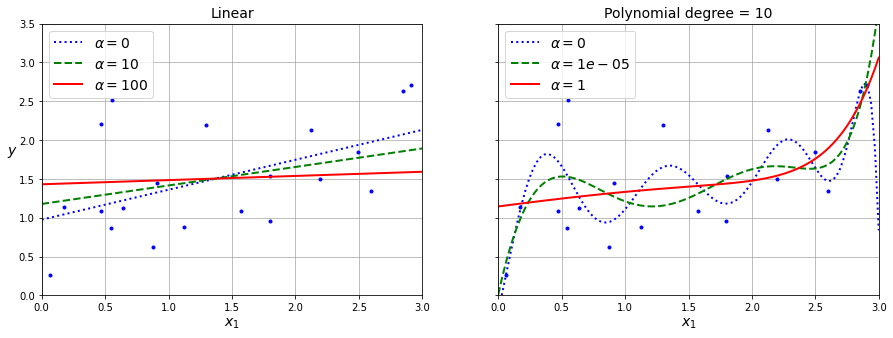

In [41]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.")
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.title("Linear")
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.title("Polynomial degree = 10")
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

Increasing $\alpha$ leads to flatter (less extreme, more reasonable) predictions. 

In other words increasing $\alpha$ increases the model's bias and decreases its variance

### Lasso Regression

_Least Absolute Shrinkage and Selection Operator Regression_

Another regularized version of linear regression. Lasso tends to eliminate the weights of the least important features (i.e. set them to zero). In other words it automatically perform feature selection.

The cost function is regularized using the $\ell_1$ norm instead of the squared $\ell_2$ norm.

The $\ell_1$ norm is $||w||_1 = \sum_{i=1}^{n} |w_i|$ 

The cost function:

$$
J(\bf{W}) = \text{MSE}(\bf{W}) + 2 \alpha
\sum_{i=1}^{n} |w_i| 
$$

$$
J(\bf{W}) = \frac{1}{m}\sum_{i=1}^{m} (\bf{W}^{T}X^{(i)}-y^{(i)})^2 + 2 \alpha
\sum_{i=1}^{n} |w_i|
$$




In [42]:
# Using Lasso 

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.intercept_, lasso_reg.coef_

(array([1.14537356]), array([0.26167212]))

In [43]:
# Using SGDRegressor with 'l1' penalty

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000, penalty='l1', alpha=0.1, eta0=0.01, 
    tol=1e-5, n_iter_no_change=100, random_state=42
)

# fit X not X_b as SGDRegressor will add the dummy feature automatically
# use y.ravel not y because fit() expects 1D targets of the shape (100, ) as opposed of (100, 2)
sgd_reg.fit(X, y.ravel()) 

sgd_reg.intercept_, sgd_reg.coef_

(array([1.04966914]), array([0.31523823]))

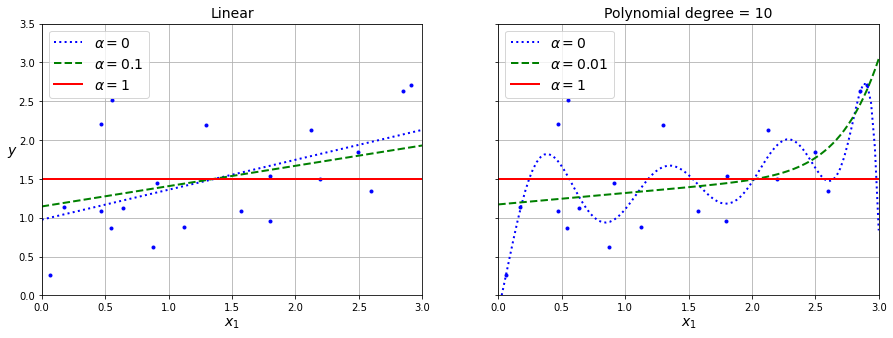

In [44]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.title("Linear")
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.title("Polynomial degree = 10")
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

The polynomial plot shows that increasing alpha seems to also reduce the degree. This is because lasso tends to eliminate the least important features (i.e. feature selection and removal)

### Elastic Net Regression

Elastic net's regularization term is a weighted sum of Ridge Regression and Lasso Regression. So it is a middle ground between the two.

$$
J(\bf{W}) = \text{MSE}(\bf{W}) + 
(1 - r)(\frac{\alpha}{m}\sum_{i=1}^{n} w_{i}^{2}) +
r (2 \alpha \sum_{i=1}^{n} |w_i|)
$$

$r$ allows you to control the mix ratio. If $r=0$ you get Ridge, if $r=1$ you get Lasso.

You should always use some regularization and avoid unregularized models. Ridge is a good starting point; however, if you think some features are not useful, you should use lasso or elastic net so their weights become 0. Elastic net is a bit more preferable because lasso may behave erratically and mixing ridge can reduce such behaviour.




In [45]:
# Using ElasticNet

from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.intercept_, elastic_net.coef_

(array([1.08639303]), array([0.30462619]))

In [46]:
# Using SGDRegressor with 'elasticnet' penalty

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000, penalty='elasticnet', alpha=0.1, l1_ratio=0.5, eta0=0.01, 
    tol=1e-5, n_iter_no_change=100, random_state=42
)

# fit X not X_b as SGDRegressor will add the dummy feature automatically
# use y.ravel not y because fit() expects 1D targets of the shape (100, ) as opposed of (100, 2)
sgd_reg.fit(X, y.ravel()) 

sgd_reg.intercept_, sgd_reg.coef_

(array([1.02098929]), array([0.3407524]))

### Early Stopping

Simple and efficient regularization technique that applies to iterative learning algorithms only (i.e. Gradient Descent). Generally, as the training goes on, training and validation errors decrease. At some point, validation error reaches a minimum and starts to increase again, at such point the model starts to overfit the training set and we stop the training.

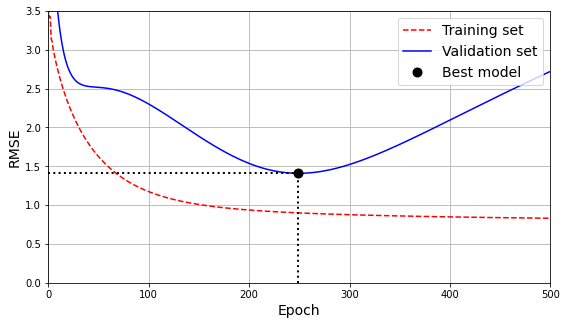

In [47]:
from copy import deepcopy
from sklearn.model_selection import train_test_split

# Generate a quadratic dataset

m = 100 # number of instances
np.random.seed(42)
X = 6 * np.random.rand(m, 1) - 3

w0 = 2    # bias
w1 = 1    # X
w2 = 0.5  # X**2

# Simple quadratic equation
y = w0 + w1 * X + w2 * X**2 + np.random.randn(m , 1)


# split the data into train/validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, shuffle=False, random_state=42)
y_train = y_train.ravel()
y_valid = y_valid.ravel()

# Add 90 degree polynomial features and scale the features
preprocessing = make_pipeline(
    PolynomialFeatures(degree=90, include_bias=False),
    StandardScaler()
)
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

# Fit a gradient descent regressor
sgd_reg = SGDRegressor(
    penalty=None, eta0=0.002, random_state=42
)

n_epochs = 500
best_valid_rmse = float('inf')
train_errors = []
valid_errors = []

for epoch in range(n_epochs):
  sgd_reg.partial_fit(X_train_prep, y_train)
  y_valid_predict = sgd_reg.predict(X_valid_prep)
  
  # Validation error
  val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
  valid_errors.append(val_error)
  if val_error < best_valid_rmse:
    best_valid_rmse = val_error
    best_model = deepcopy(sgd_reg)
    best_epoch = epoch
  
  # Trainin error
  y_train_predict = sgd_reg.predict(X_train_prep)
  train_errors.append(mean_squared_error(y_train, y_train_predict, squared=False))

plt.figure(figsize=(9, 5))
plt.plot(train_errors, "r--", label="Training set")
plt.plot(valid_errors, "b-", label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "ko", markersize=9, label="Best model")
plt.plot([best_epoch, best_epoch], [0, best_valid_rmse], "k:", linewidth=2)
plt.plot([0, best_epoch], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, n_epochs, 0, 3.5])
plt.legend(loc="upper right")
plt.show()